In [ ]:
from copy import deepcopy

import torch
from torch import nn
from torch.nn import functional as F
from conv_cp import CPConv2d

In [ ]:
!pip install torchmetrics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 27.5 MB/s eta 0:00:00


In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -qq kagglecatsanddogs_5340.zip
!rm -rf PetImages/Cat/666.jpg PetImages/Dog/11702.jpg readme\[1\].txt CDLA-Permissive-2.0.pdf

--2024-12-15 03:14:25--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.220.113.200, 2a02:26f0:1180:382::317f, 2a02:26f0:1180:39e::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.220.113.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   115MB/s    in 8.4s    

2024-12-15 03:14:33 (94.0 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/cp_models.zip

Archive:  /content/gdrive/MyDrive/cp_models.zip
  inflating: new_cp_model_10_0.9     
  inflating: __MACOSX/._new_cp_model_10_0.9  
  inflating: new_cp_model_10_0.7     
  inflating: __MACOSX/._new_cp_model_10_0.7  
  inflating: new_cp_model_10_0.5     
  inflating: __MACOSX/._new_cp_model_10_0.5  
  inflating: new_cp_model_9_0.9      
  inflating: __MACOSX/._new_cp_model_9_0.9  
  inflating: new_cp_model_9_0.7      
  inflating: __MACOSX/._new_cp_model_9_0.7  
  inflating: new_cp_model_9_0.5      
  inflating: __MACOSX/._new_cp_model_9_0.5  
  inflating: new_cp_model_6_0.9      
  inflating: __MACOSX/._new_cp_model_6_0.9  
  inflating: new_cp_model_6_0.7      
  inflating: __MACOSX/._new_cp_model_6_0.7  
  inflating: new_cp_model_6_0.5      
  inflating: __MACOSX/._new_cp_model_6_0.5  
  inflating: cp_models.pkl           
  inflating: __MACOSX/._cp_models.pkl  


In [ ]:
from torchmetrics.functional import accuracy
from torchvision.models import resnet18

model = resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


In [ ]:
import pickle
with open('cp_models.pkl', 'rb') as f:
    cp_list = pickle.load(f)

In [ ]:
def get_parameter_count(model):
    return sum(p.numel() for p in model.parameters())

def max_rank(layer, step=1):
    sum_shape, dot_shape = 0, 1
    shape_ = layer.weight.shape
    for i in range(len(shape_)):
        sum_shape += shape_[i]
        dot_shape *= shape_[i]

    return dot_shape // sum_shape

def get_cp_model(ratio=1):
    cp_model = deepcopy(model)
    for name_1, layer_1 in cp_model.named_children():
        if isinstance(layer_1, nn.Conv2d):
            setattr(cp_model, name_1, CPConv2d(layer_1, int(max_rank(layer_1) * ratio)))

        if isinstance(layer_1, nn.Sequential):
            atr_1 = getattr(cp_model, name_1)

            for name_2, layer_2 in layer_1.named_children():
                atr_2 = atr_1[int(name_2)]

                for name_3, layer_3 in layer_2.named_children():
                    if isinstance(layer_3, nn.Conv2d):
                        setattr(atr_2, name_3, CPConv2d(layer_3, int(max_rank(layer_3) * ratio)))

                atr_1[int(name_2)] = atr_2
            setattr(cp_model, name_1, atr_1)
    return cp_model


In [ ]:
import glob
import warnings
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

%matplotlib inline
warnings.filterwarnings("ignore")

device = "cuda"

transform=Compose(
        [
            Resize((224, 224)),
            ToTensor(),
            Normalize(0.5, 1),
        ])

fashion_mnist_train = torchvision.datasets.FashionMNIST(
    "./data", download=True, transform=transform)

train_dataloader = DataLoader(
    fashion_mnist_train, batch_size=128, shuffle=True, num_workers=4
)

# Validation data
fashion_mnist_val = torchvision.datasets.FashionMNIST(
    "./data",
    train=False,
    download=True,
    transform=transform)

val_dataloader = DataLoader(fashion_mnist_val, batch_size=128, num_workers=4)

In [ ]:
!pip install pytorch_lightning -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 28.0 MB/s eta 0:00:00


In [ ]:
import pytorch_lightning as pl
from torchmetrics.functional import accuracy

def train_epoch(
    model,
    data_loader,
    optimizer,
    return_losses=False,
    device="cuda",
):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            # move Batch to GPU
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            # update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # update description for tqdm
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, device="cuda"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    return metrics

class MNIST_model(pl.LightningModule):
    def __init__(self, cp: bool = False, i = 0) -> None:
        super().__init__()
        self.cp = cp

        if cp:
            self.model = cp_list[i]
        else:
            self.model = resnet18(pretrained=True)

        self.model.fc = nn.Identity()
        self.classifier = nn.Linear(512, 10)
        self.optimizer = torch.optim.Adam(self.classifier.parameters())

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        x = x.expand(-1, 3, -1, -1)
        with torch.no_grad():
            features = self.model(x)
        preds = self.classifier(features)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.accuracy = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task='multiclass', num_classes=10)
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", self.accuracy, prog_bar=True)

In [ ]:
import time
from pytorch_lightning.loggers import CSVLogger



times = []
acc_list = []
n_params = []
for i in range(len(cp_list)):
    mnist = MNIST_model(cp=True, i=i)
    start = time.time()
    trainer = pl.Trainer(accelerator="auto", max_epochs=1)
    trainer.fit(mnist, train_dataloader, val_dataloader)
    end = time.time()
    times.append(end-start)
    acc_list.append(trainer.logged_metrics['accuracy'])
    n_params.append(get_parameter_count(mnist))


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 286 K  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
291 K     Trainable params
0         Non-trainable params
291 K     Total params
1.167     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 507 K  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
512 K     Trainable params
0         Non-trainable params
512 K     Total params
2.050     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 727 K  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
732 K     Trainable params
0         Non-trainable params
732 K     Total params
2.929     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 1.3 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.134     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 2.4 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.532     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 3.5 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.928    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 4.6 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.326    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 5.7 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
22.728    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 6.8 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.118    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 7.9 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M     Total params
31.513    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 9.0 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
9.0 M     Trainable params
0         Non-trainable params
9.0 M     Total params
35.912    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 10.1 M | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
10.1 M    Trainable params
0         Non-trainable params
10.1 M    Total params
40.307    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
mnist = MNIST_model(cp=False)
start = time.time()
trainer = pl.Trainer(accelerator="auto", max_epochs=1)
trainer.fit(mnist, train_dataloader, val_dataloader)
end = time.time()
times.append(end-start)
acc_list.append(trainer.logged_metrics['accuracy'])
n_params.append(get_parameter_count(mnist))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 11.2 M | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
n_params = list(map(lambda x: round(x/1e6, 2), n_params))

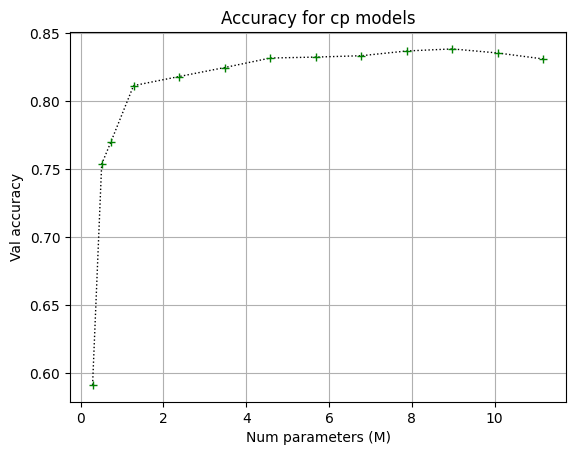

In [ ]:
plt.plot(n_params, acc_list, 'k-', linestyle = ":", lw=1)
plt.plot(n_params, acc_list, 'b+', c='g')

plt.grid()
plt.xlabel('Num parameters (M)')
plt.ylabel('Val accuracy')
plt.title('Accuracy for cp models')
plt.savefig('def_approach.jpg', format='jpeg')

In [ ]:
times

[77.48337888717651,
 72.35053706169128,
 78.45830798149109,
 78.56652617454529,
 90.7133560180664,
 106.63963866233826,
 121.93426465988159,
 142.60009908676147,
 156.2647933959961,
 172.44390273094177,
 194.28324270248413,
 209.2667679786682,
 89.50058579444885]

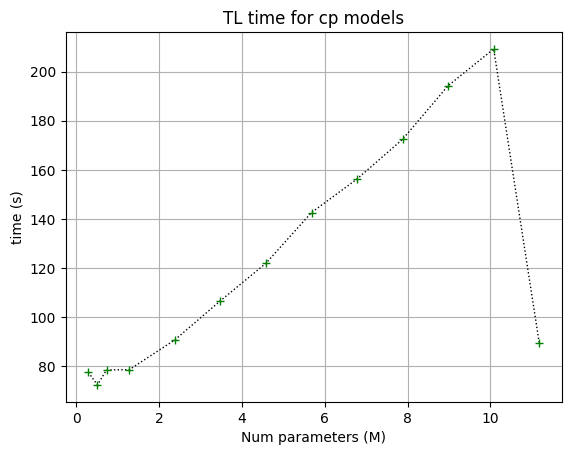

In [ ]:
plt.plot(n_params, times, 'k-', linestyle = ":", lw=1)
plt.plot(n_params, times, 'b+', c='g')

plt.grid()
plt.xlabel('Num parameters (M)')
plt.ylabel('time (s)')
plt.title('TL time for cp models')
plt.savefig('def_approach_time.jpg', format='jpeg')

In [ ]:
with open('new_cp_model_9_0.5', 'rb') as f:
    cp_list = pickle.load(f)

In [ ]:
import glob
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

%matplotlib inline
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = ImageFolder(
    "./PetImages",
    transform=Compose(
        [
            Resize((224, 224)),
            ToTensor(),
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)),
        ]
    ),
)
train_set, val_set = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False)

In [ ]:
import pytorch_lightning as pl
from torchmetrics.functional import accuracy


class CatsVSDogsResnet(pl.LightningModule):
    def __init__(self, cp: bool = False, i = 0) -> None:
        super().__init__()
        self.cp = cp

        if cp:
            self.model = cp_list[i]
        else:
            self.model = resnet18(pretrained=True)

        self.model.fc = nn.Identity()
        self.classifier = nn.Linear(512, 2)
        self.optimizer = torch.optim.Adam(self.classifier.parameters())

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        with torch.no_grad():
            features = self.model(x)
        preds = self.classifier(features)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task = 'binary')
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [ ]:
times = []
acc_list = []
n_params = []
for i in range(len(cp_list)):
    cvd = CatsVSDogsResnet(cp=True, i=i)
    start = time.time()
    trainer = pl.Trainer(accelerator="auto", max_epochs=1)
    trainer.fit(cvd, train_dataloader, val_dataloader)
    end = time.time()
    times.append(end-start)
    acc_list.append(trainer.logged_metrics['accuracy'])
    n_params.append(get_parameter_count(mnist))


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 286 K  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
287 K     Trainable params
0         Non-trainable params
287 K     Total params
1.151     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 507 K  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
508 K     Trainable params
0         Non-trainable params
508 K     Total params
2.033     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 727 K  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
728 K     Trainable params
0         Non-trainable params
728 K     Total params
2.913     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 1.3 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.118     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 2.4 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.515     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 3.5 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.912    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 4.6 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.309    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 5.7 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
22.712    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 6.8 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.101    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 7.9 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M     Total params
31.497    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 9.0 M  | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
9.0 M     Trainable params
0         Non-trainable params
9.0 M     Total params
35.895    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 10.1 M | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
10.1 M    Trainable params
0         Non-trainable params
10.1 M    Total params
40.291    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
cvd = CatsVSDogsResnet(cp=False)
start = time.time()
trainer = pl.Trainer(accelerator="auto", max_epochs=1)
trainer.fit(cvd, train_dataloader, val_dataloader)
end = time.time()
times.append(end-start)
acc_list.append(trainer.logged_metrics['accuracy'])
n_params.append(get_parameter_count(mnist))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 11.2 M | train
1 | classifier | Linear           | 1.0 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
n_params = []
for i in range(len(cp_list)):
    n_params.append(get_parameter_count(cp_list[i]))
n_params.append(get_parameter_count(model))
n_params = list(map(lambda x: round(x/1e6, 2), n_params))

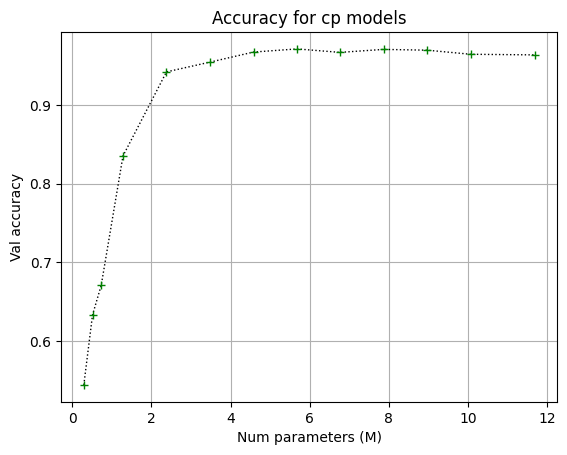

In [ ]:

plt.plot(n_params, acc_list, 'k-', linestyle = ":", lw=1)
plt.plot(n_params, acc_list, 'b+', c='g')

plt.grid()
plt.xlabel('Num parameters (M)')
plt.ylabel('Val accuracy')
plt.title('Accuracy for cp models')
plt.savefig('def_approach_cvd.jpg', format='jpeg')

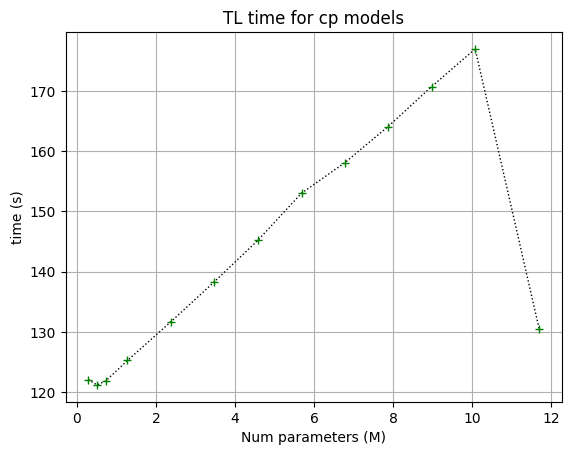

In [ ]:
plt.plot(n_params, times, 'k-', linestyle = ":", lw=1)
plt.plot(n_params, times, 'b+', c='g')

plt.grid()
plt.xlabel('Num parameters (M)')
plt.ylabel('time (s)')
plt.title('TL time for cp models')
plt.savefig('def_approach_time_cvd.jpg', format='jpeg')

In [ ]:
transform=Compose(
        [
            ToTensor(),
            Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

cifar_train = torchvision.datasets.CIFAR10(
    "./data", download=True, transform=transform)

train_dataloader = DataLoader(
    cifar_train, batch_size=128, shuffle=True, num_workers=4
)

# Validation data
cifar_val = torchvision.datasets.CIFAR10(
    "./data",
    train=False,
    download=True,
    transform=transform)

val_dataloader = DataLoader(cifar_val, batch_size=128, num_workers=4)


  0%|          | 0.00/170M [00:00<?, ?B/s]
  0%|          | 65.5k/170M [00:00<07:47, 364kB/s]
  0%|          | 131k/170M [00:00<07:55, 358kB/s] 
  0%|          | 492k/170M [00:00<02:36, 1.08MB/s]
  1%|          | 1.61M/170M [00:00<00:45, 3.71MB/s]
  2%|▏         | 3.57M/170M [00:00<00:20, 8.04MB/s]
  4%|▎         | 6.26M/170M [00:00<00:12, 13.3MB/s]
  5%|▌         | 9.18M/170M [00:00<00:09, 17.8MB/s]
  8%|▊         | 13.0M/170M [00:01<00:06, 23.4MB/s]
 10%|▉         | 16.3M/170M [00:01<00:05, 26.1MB/s]
 12%|█▏        | 19.8M/170M [00:01<00:05, 28.7MB/s]
 13%|█▎        | 22.8M/170M [00:01<00:05, 29.1MB/s]
 16%|█▌        | 26.6M/170M [00:01<00:04, 31.6MB/s]
 18%|█▊        | 29.9M/170M [00:01<00:04, 31.8MB/s]
 20%|█▉        | 33.3M/170M [00:01<00:04, 32.6MB/s]
 21%|██▏       | 36.6M/170M [00:01<00:04, 32.7MB/s]
 23%|██▎       | 40.0M/170M [00:01<00:03, 33.1MB/s]
 25%|██▌       | 43.4M/170M [00:01<00:03, 33.4MB/s]
 28%|██▊       | 46.9M/170M [00:02<00:03, 33.9MB/s]
 30%|██▉       | 50.3M/

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class CIFAR_model(pl.LightningModule):
    def __init__(self, cp: bool = False, i = 0) -> None:
        super().__init__()
        self.cp = cp

        if cp:
            self.model = cp_list[i]
        else:
            self.model = resnet18(pretrained=True)

        self.model.fc = nn.Identity()
        self.classifier = nn.Linear(512, 10)
        self.optimizer = torch.optim.Adam(self.classifier.parameters())

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x) -> torch.Tensor:
        with torch.no_grad():
            features = self.model(x)
        preds = self.classifier(features)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.accuracy = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task='multiclass', num_classes=10)
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", self.accuracy, prog_bar=True)

In [ ]:
times = []
acc_list = []
n_params = []
for i in range(len(cp_list)):
    cifar = CIFAR_model(cp=True, i=i)
    start = time.time()
    trainer = pl.Trainer(accelerator="auto", max_epochs=1)
    trainer.fit(cifar, train_dataloader, val_dataloader)
    end = time.time()
    times.append(end-start)
    acc_list.append(trainer.logged_metrics['accuracy'])
    n_params.append(get_parameter_count(mnist))


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 286 K  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
291 K     Trainable params
0         Non-trainable params
291 K     Total params
1.167     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 507 K  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
512 K     Trainable params
0         Non-trainable params
512 K     Total params
2.050     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 727 K  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
732 K     Trainable params
0         Non-trainable params
732 K     Total params
2.929     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 1.3 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.134     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 2.4 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.532     Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 3.5 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.928    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 4.6 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.326    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 5.7 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
22.728    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 6.8 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.118    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 7.9 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M     Total params
31.513    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 9.0 M  | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
9.0 M     Trainable params
0         Non-trainable params
9.0 M     Total params
35.912    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 10.1 M | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
10.1 M    Trainable params
0         Non-trainable params
10.1 M    Total params
40.307    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
cifar = CIFAR_model(cp=False)
start = time.time()
trainer = pl.Trainer(accelerator="auto", max_epochs=1)
trainer.fit(cifar, train_dataloader, val_dataloader)
end = time.time()
times.append(end-start)
acc_list.append(trainer.logged_metrics['accuracy'])
n_params.append(get_parameter_count(mnist))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 11.2 M | train
1 | classifier | Linear           | 5.1 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
n_params = []
for i in range(len(cp_list)):
    n_params.append(get_parameter_count(cp_list[i]))
n_params.append(get_parameter_count(model))
n_params = list(map(lambda x: round(x/1e6, 2), n_params))

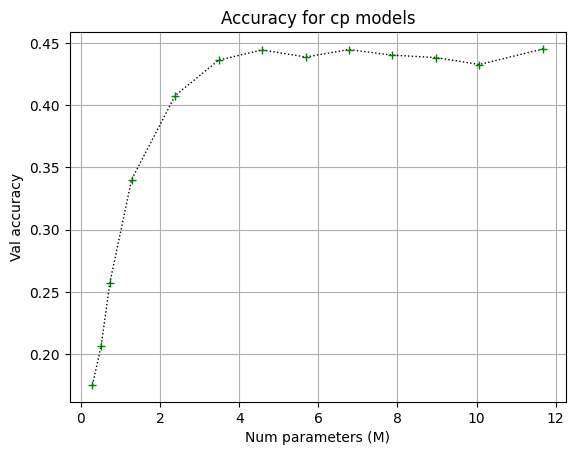

In [ ]:
plt.plot(n_params, acc_list, 'k-', linestyle = ":", lw=1)
plt.plot(n_params, acc_list, 'b+', c='g')

plt.grid()
plt.xlabel('Num parameters (M)')
plt.ylabel('Val accuracy')
plt.title('Accuracy for cp models')
plt.savefig('def_approach_cifar10.jpg', format='jpeg')

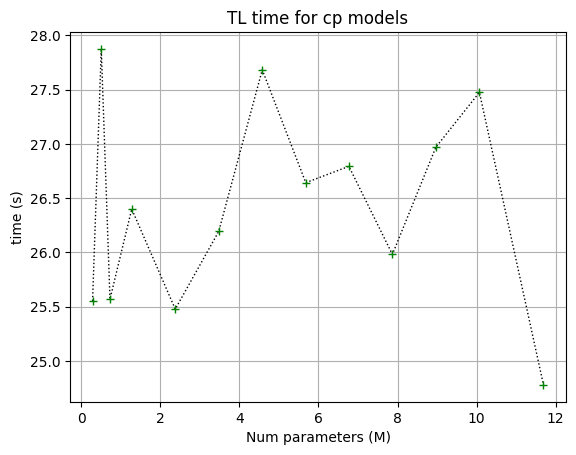

In [ ]:
plt.plot(n_params, times, 'k-', linestyle = ":", lw=1)
plt.plot(n_params, times, 'b+', c='g')

plt.grid()
plt.xlabel('Num parameters (M)')
plt.ylabel('time (s)')
plt.title('TL time for cp models')
plt.savefig('def_approach_time_cifar.jpg', format='jpeg')